## Import Libraries

In [1]:
import argparse
from itertools import count
import os, sys, random
import numpy as np
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from torch.distributions import Normal
from tensorboardX import SummaryWriter

In [2]:
device = 'cuda' if torch.cuda.is_available() else 'cpu'

## Load Environment

We wil use Pendulum environment and will use Deep Deterministic Policy Gradient (DDPG) approach to train Actor-Critic Model

In [3]:
import gym
env = gym.make('Pendulum-v1', render_mode="rgb_array")
directory = ''


Info
- define random seed
- get input state information

gym env provides information about state of the agent

In [4]:
random_seed = 10
torch.manual_seed(random_seed)
np.random.seed(random_seed)

state_dim = env.observation_space.shape[0]
action_dim = env.action_space.shape[0]
max_action = float(env.action_space.high[0])
min_Val = torch.tensor(1e-7).float().to(device) # min value
print(state_dim, action_dim, min_Val, max_action)

3 1 tensor(1.0000e-07) 2.0


## Relay Buffer
- Replay buffer is created to save state, action, reward, and next state information of the agent.
- This buffer data is used to train the Actor-Critic model
- define the size of the buffer (max_size)

In [5]:
class Replay_buffer():
    '''
    Expects tuples of (state, next_state, action, reward, done)
    '''
    def __init__(self, max_size=100000):
        self.storage = []
        self.max_size = max_size
        self.ptr = 0

    def push(self, data):
        if len(self.storage) == self.max_size:
            self.storage[int(self.ptr)] = data
            self.ptr = (self.ptr + 1) % self.max_size
        else:
            self.storage.append(data)

    def sample(self, batch_size):
        ind = np.random.randint(0, len(self.storage), size=batch_size)
        x, y, u, r, d = [], [], [], [], []

        for i in ind:
            X, Y, U, R, D = self.storage[i]
            x.append(np.array(X, copy=False))
            y.append(np.array(Y, copy=False))
            u.append(np.array(U, copy=False))
            r.append(np.array(R, copy=False))
            d.append(np.array(D, copy=False))

        return np.array(x), np.array(y), np.array(u), np.array(r).reshape(-1, 1), np.array(d).reshape(-1, 1)

## Create an Actor model
Define
- input state dimension
- action dimension

In [6]:
class Actor(nn.Module):
    def __init__(self, state_dim, action_dim, max_action):
        super(Actor, self).__init__()

        self.l1 = nn.Linear(state_dim, 400)
        self.l2 = nn.Linear(400, 300)
        self.l3 = nn.Linear(300, action_dim)

        self.max_action = max_action

    def forward(self, x):
        x = F.relu(self.l1(x))
        x = F.relu(self.l2(x))
        x = self.max_action * torch.tanh(self.l3(x))
        return x

## Now create a Critic model
Define
- input state dimension
- action dimension

In [7]:
class Critic(nn.Module):
    def __init__(self, state_dim, action_dim):
        super(Critic, self).__init__()

        self.l1 = nn.Linear(state_dim + action_dim, 400)
        self.l2 = nn.Linear(400 , 300)
        self.l3 = nn.Linear(300, 1)

    def forward(self, x, u):
        x = F.relu(self.l1(torch.cat([x, u], 1)))
        x = F.relu(self.l2(x))
        x = self.l3(x)
        return x

Now the actor and cricit model has been defined, let's create DDPG class 

Define
- actor
- actor target
- optimizer for actor

- critic
- critic target
- critic optimizer

- tau, gamma, batch_size, update_iteration

In [8]:

class DDPG(object):
    def __init__(self, state_dim, action_dim, max_action):
        self.actor = Actor(state_dim, action_dim, max_action).to(device)
        self.actor_target = Actor(state_dim, action_dim, max_action).to(device)
        self.actor_target.load_state_dict(self.actor.state_dict())
        self.actor_optimizer = optim.Adam(self.actor.parameters(), lr=1e-4)

        self.critic = Critic(state_dim, action_dim).to(device)
        self.critic_target = Critic(state_dim, action_dim).to(device)
        self.critic_target.load_state_dict(self.critic.state_dict())
        self.critic_optimizer = optim.Adam(self.critic.parameters(), lr=1e-3)
        self.replay_buffer = Replay_buffer()
        self.writer = SummaryWriter(directory)

        self.num_critic_update_iteration = 0
        self.num_actor_update_iteration = 0
        self.num_training = 0
        self.update_iteration = 200
        self.tau = 0.005
        self.gamma = 0.99
        self.batch_size = 100

    def select_action(self, state):
        state = torch.FloatTensor(state.reshape(1, -1)).to(device)
        return self.actor(state).cpu().data.numpy().flatten()

    def update(self):

        for it in range(self.update_iteration):
            # Sample replay buffer
            x, y, u, r, d = self.replay_buffer.sample(self.batch_size)
            state = torch.FloatTensor(x).to(device)
            action = torch.FloatTensor(u).to(device)
            next_state = torch.FloatTensor(y).to(device)
            done = torch.FloatTensor(1-d).to(device)
            reward = torch.FloatTensor(r).to(device)

            # Compute the target Q value
            target_Q = self.critic_target(next_state, self.actor_target(next_state))
            target_Q = reward + (done * self.gamma * target_Q).detach()

            # Get current Q estimate
            current_Q = self.critic(state, action)

            # Compute critic loss
            critic_loss = F.mse_loss(current_Q, target_Q)
            self.writer.add_scalar('Loss/critic_loss', critic_loss, global_step=self.num_critic_update_iteration)
            # Optimize the critic
            self.critic_optimizer.zero_grad()
            critic_loss.backward()
            self.critic_optimizer.step()

            # Compute actor loss
            actor_loss = -self.critic(state, self.actor(state)).mean()
            self.writer.add_scalar('Loss/actor_loss', actor_loss, global_step=self.num_actor_update_iteration)

            # Optimize the actor
            self.actor_optimizer.zero_grad()
            actor_loss.backward()
            self.actor_optimizer.step()

            # Update the frozen target models
            for param, target_param in zip(self.critic.parameters(), self.critic_target.parameters()):
                target_param.data.copy_(self.tau * param.data + (1 - self.tau) * target_param.data)

            for param, target_param in zip(self.actor.parameters(), self.actor_target.parameters()):
                target_param.data.copy_(self.tau * param.data + (1 - self.tau) * target_param.data)

            self.num_actor_update_iteration += 1
            self.num_critic_update_iteration += 1

    def save(self):
        torch.save(self.actor.state_dict(), directory + 'actor.pth')
        torch.save(self.critic.state_dict(), directory + 'critic.pth')
        # print("====================================")
        # print("Model has been saved...")
        # print("====================================")

    def load(self):
        self.actor.load_state_dict(torch.load(directory + 'actor.pth'))
        self.critic.load_state_dict(torch.load(directory + 'critic.pth'))
        print("====================================")
        print("model has been loaded...")
        print("====================================")


In [9]:
agent = DDPG(state_dim, action_dim, max_action)
ep_r = 0

## Train The Actor-Critic Model
Define
- max episode
- max time step the simulation will run
- exploration_noise

In [10]:
def train(max_episode = 100, log_interval=5, render=False, time_steps = 200, exploration_noise = 0.01):
    all_rewards = []
    for i in range(max_episode):
        total_reward = 0
        step =0
        total_step = 0
        state = env.reset()
        state = np.asarray(state[0])
        for t in range(time_steps):
            action = agent.select_action(state)
            # print(action)
            action = (action + np.random.normal(0, exploration_noise, size=env.action_space.shape[0])).clip(
                env.action_space.low, env.action_space.high)

            next_state, reward, done, info, _ = env.step(action)
            if render:
                env.render()
            agent.replay_buffer.push((state, next_state, action, reward, 0))

            state = next_state
            if done:
                break
            step += 1
            total_reward += reward
        total_step += step+1
        all_rewards.append(total_reward)
        print("Total T:{} Episode: \t{} Total Reward: \t{:0.2f}".format(total_step, i, total_reward))
        agent.update()

        if i % log_interval == 0:
            agent.save()
    return all_rewards
                

In [11]:
rewards = train()

/Users/sid/.pyenv/versions/3.11.2/envs/mlci-venv-3.11.2/lib/python3.11/site-packages/gym/utils/passive_env_checker.py:233: DeprecationWarning: `np.bool8` is a deprecated alias for `np.bool_`.  (Deprecated NumPy 1.24)
  if not isinstance(terminated, (bool, np.bool8)):


Total T:201 Episode: 	0 Total Reward: 	-1569.56
Total T:201 Episode: 	1 Total Reward: 	-1630.40
Total T:201 Episode: 	2 Total Reward: 	-1487.58
Total T:201 Episode: 	3 Total Reward: 	-1587.18
Total T:201 Episode: 	4 Total Reward: 	-1435.34
Total T:201 Episode: 	5 Total Reward: 	-1350.03
Total T:201 Episode: 	6 Total Reward: 	-1499.07
Total T:201 Episode: 	7 Total Reward: 	-1279.38
Total T:201 Episode: 	8 Total Reward: 	-1327.77
Total T:201 Episode: 	9 Total Reward: 	-1262.52
Total T:201 Episode: 	10 Total Reward: 	-1156.69
Total T:201 Episode: 	11 Total Reward: 	-508.04
Total T:201 Episode: 	12 Total Reward: 	-628.66
Total T:201 Episode: 	13 Total Reward: 	-635.22
Total T:201 Episode: 	14 Total Reward: 	-1062.57
Total T:201 Episode: 	15 Total Reward: 	-1023.69
Total T:201 Episode: 	16 Total Reward: 	-1025.66
Total T:201 Episode: 	17 Total Reward: 	-635.86
Total T:201 Episode: 	18 Total Reward: 	-985.55
Total T:201 Episode: 	19 Total Reward: 	-889.40
Total T:201 Episode: 	20 Total Rewar

Plot reward over episodes

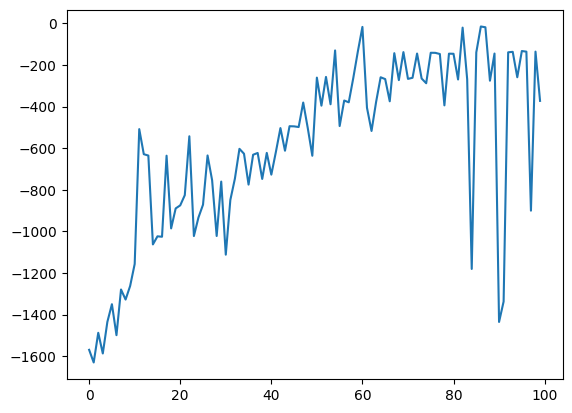

In [12]:
import matplotlib.pyplot as plt

episodes = [i for i in range(len(rewards))]
plt.plot(episodes, rewards)
plt.show()

In [13]:
def test(test_iteration=10, max_length_of_trajectory=100):
    ep_r = 0
    agent.load()
    for i in range(test_iteration):
        state = env.reset()
        state = np.asarray(state[0])
        for t in count():
            action = agent.select_action(state)
            # print(action)
            next_state, reward, done, info, _ = env.step(action)
            ep_r += reward
            env.render()
            if done or t >= max_length_of_trajectory:
                print("Ep_i \t{}, the ep_r is \t{:0.2f}, the step is \t{}".format(i, ep_r, t))
                ep_r = 0
                break
            state = next_state

In [16]:
test()

model has been loaded...
Ep_i 	0, the ep_r is 	-450.16, the step is 	100
Ep_i 	1, the ep_r is 	-229.09, the step is 	100
Ep_i 	2, the ep_r is 	-4.75, the step is 	100
Ep_i 	3, the ep_r is 	-368.89, the step is 	100
Ep_i 	4, the ep_r is 	-131.01, the step is 	100
Ep_i 	5, the ep_r is 	-124.26, the step is 	100
Ep_i 	6, the ep_r is 	-241.80, the step is 	100
Ep_i 	7, the ep_r is 	-2.37, the step is 	100
Ep_i 	8, the ep_r is 	-5.83, the step is 	100
Ep_i 	9, the ep_r is 	-250.08, the step is 	100
